분석을 위한 데이터 클리닝과 준비
=====
결측값
-----

In [1]:
# initial imports
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("white")

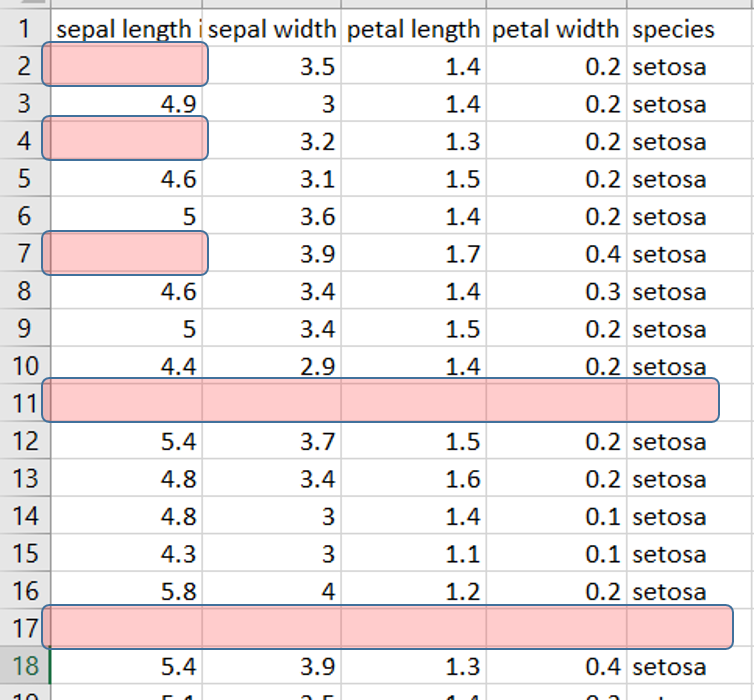

In [2]:
# execute this cell to show the image
from IPython.display import Image
Image("../images/missing_data_spreadsheet.png")

In [3]:
# 결측값을 갖는 iris 데이터셋 로딩
df = pd.read_csv("../data/iris_missing_values.csv")
df.index.name = "record"
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species
record,,,,,
0,NaN,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,NaN,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


데이터프레임의 결측값이 NaN으로 표시되어 있다.
결측값을 naive하게 찾아내고, 세고, 제거하는 것은 어려운 일이다. 이 부분에서 판다스의 내장 함수가 유용하게 사용된다. .isnull() 기법을 통해 모든 널값을 찾을 수 있다.

In [4]:
df['sepal length in cm'].isnull()

record
0       True
1      False
2       True
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149    False
Name: sepal length in cm, Length: 150, dtype: bool

In [5]:
# check if any missing values in column
df['sepal length in cm'].isnull().values.any()

True

In [6]:
# get the number of many missing values in column
df['sepal length in cm'].isnull().values.sum()

6

결측값은 원하는 값으로 대체할 수 있다. 편의상 빈 셀에 문자열 값을 채워넣는다.

In [7]:
# df_example이란 새로운 데이터프레임에 저장!
df_example = df['sepal length in cm'].fillna('example')
df_example.head()

record
0    example
1        4.9
2    example
3        4.6
4          5
Name: sepal length in cm, dtype: object

교체하길 원치 않는 결측값의 행이나 열을 쉽게 제거할 수 있다.

In [9]:
#'na'무엇의 약자..?
df_dropped = df.dropna(axis=0)
df_dropped.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species
record,,,,,
1,4.9,3.0,1.4,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa


In [8]:
#결측값이 있는 열 제거
df_dropped = df.dropna(axis=1)
df_dropped.head()

""
record
0
1
2
3
4


결측값을 대체하기 위한 임퓨팅
-----
띄엄띄엄 결측값이 있는 경우, 빈 셀의 대체값을 예측할 수 있다(와 쩐다..). 이 값들을 예측하는 수학적 장치를 임퓨터라고 부른다. 사이킷런은 SimpleImputor()라 불리는 기법을 내장하고 있다. 이 기법은 두 가지 옵션을 갖고 있다.
* missing_values: 결측값의 형태(nan, 0, n/a etc.)
* strategy: 임퓨트 기법을 의미한다. 선택은 평균/중앙/최빈값, 상수 넷 중 하나다. 상수로 설정하면 상수를 정하기 위해 fill_value 옵션을 사용할 수 있다.

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#define columns to impute on
cols = ['sepal length in cm',
         'sepal width in cm',
         'petal length in cm',
         'petal width in cm',]

# fit imputer and transform dataset, store in df_new
out_imp = imputer.fit_transform(df[cols]) #데이터 변환
df_new = pd.DataFrame(data=out_imp, columns=cols)
df_new = pd.concat([df_new, df[['species']]], axis=1)
df_new.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species
0,5.870139,3.5,1.4,0.2,setosa
1,4.900000,3.0,1.4,0.2,setosa
2,5.870139,3.2,1.3,0.2,setosa
3,4.600000,3.1,1.5,0.2,setosa
4,5.000000,3.6,1.4,0.2,setosa


특징 스케일링(Feature Scaling)
-----
A mathematical property is considered scale-invariant if it does not change when multiplying specified inputs by a constant. For instance, the shape of a curve is invariant to the size of the input lengths.
((상수를 곱해도 성질이 바뀌지 않는다면, 그 수학적 성질은 '스케일 불변'으로 여긴다. 곡선의 모양이 입력의 강도와 상관없이 동일한 경우가 그 예다. 모든 데이터에(전체 분포에) 3을 곱했다고 생각해보자. 그리고 이 데이터셋은 음의 편향이 있는 분포를 가졌다고 가정하자. 3을 곱해도 이 분포는 여전히 음의 편향을 가졌을 것이다.))

Scaling is important for transformation and learning algorithms that are not scale-invariant. Two examples of algorithms that lack scale-invariance are principle component analysis (PCA) and penalized regression. In these cases, large values dominate the parameter space inside the algorithm. 그 결과 일부 특징(usually the ones on the largest scales)이 데이터 마이닝 결과에 과도한 영향을 미치게 된다. 이 문제를 해결하려면 각 특징을 비슷한 스케일로 적용하는 것이다. 뒤에 나오는 기법들은 스케일이 아닌 분산과 편향에 집중하게 된다. The most common methods for correcting scale is and normalization and standardization.

In [11]:
df = pd.read_csv("../data/iris.csv")
df.index.name = "record"

# define columns to scale
cols = ['sepal length in cm',
        'sepal width in cm',
        'petal length in cm',
        'petal width in cm']

#### Normalization

Normalization is used to rescale each feature space so that all values fall between 0 and 1 (or alternatively between -1 and 1). There are multiple ways to do normalization, but the most common method is the routine coded into Scikit-learn's MinMaxScaler() function. Here is the equation for this normalization method:

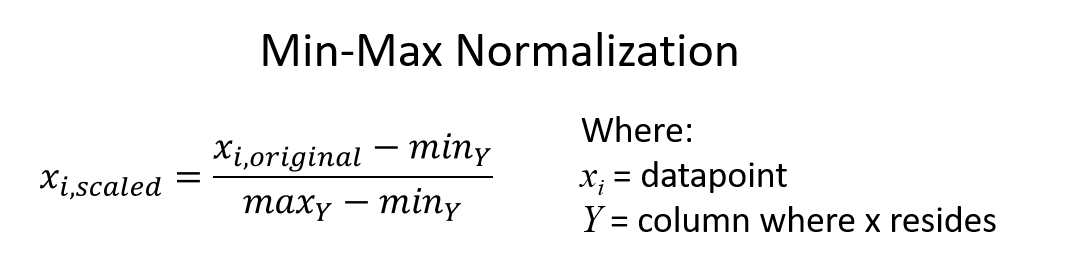

In [12]:
# execute this cell to show the image
from IPython.display import Image
Image("../images/min_mix_scaler.png")

*이 변환을 이상치로부터 보호할 수 있는 방법은 없으며, 이상치는 **정규화하기 전에** 제거해야 한다. 그렇지 않으면 합당한 데이터들이 0-1 전체의 범위에 적절히 펼쳐지지 못하고 유용한 데이터는 더 적은 범위로 모이게 된다.

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# normalize the data and store in out_scaled numpy array
out_scaled = scaler.fit_transform(df[cols])

표준화는 같은 스케일상의 각 특징 공간 내에서 변동을 위치시키기 위해 사용되며, spreading the data across unit variance and centering at 0. Other values can be chosen for advanced standardization but variance=1 and mean=0 is the most common.

*TIP: There is no cap on the min/max values of standardized data, which makes it fairly robust to outliers and actually leaves them identifiable after the transformation. Furthermore Scikit-learn has a robust_scale method for even more robustness by using interquartile range to measure variation instead of standard deviation. For this reason, I recommend using standardization as your main rescale method as opposed to normalization.

Handling Categorical Data
-----

In [14]:
df = pd.read_csv("../data/long_jump.csv")
df.set_index('Person', inplace=True)

### Ordinal Data Encoding
운동복사이즈, 신발사이즈와 같이 큰 값이 실제로 큰 것을 의미하며, 크기는 크기 순서대로 나열할 수 있어 순서적 변수라고 할 수 있다. 

In [15]:
cats = ['Jersey Size','Shoe Size']
df[cats]

,Jersey Size,Shoe Size
Person,,
Thomas,small,7
Jane,medium,10
Vaughn,large,12
Vera,medium,9
Vincent,large,12
Lei-Ann,small,7


In [16]:
from sklearn.preprocessing import OrdinalEncoder
# Encode categorical features as an integer array.
enc = OrdinalEncoder()

out_enc = enc.fit_transform(df[cats])
print("identified categories:")
print(enc.categories_)
print("encoded data:")
print(out_enc)

identified categories:
[array(['large', 'medium', 'small'], dtype=object), array([ 7,  9, 10, 12])]
encoded data:
[[2. 0.]
 [1. 2.]
 [0. 3.]
 [1. 1.]
 [0. 3.]
 [2. 0.]]


In [17]:
# overwrite categorical features in original dataframe
df[cats] = out_enc
df.head()

,Age,Height,Weight,Training Hours/week,Jersey Color,Jersey Size,Shoe Size,Long Jump
Person,,,,,,,,
Thomas,12,57.5,73.4,6.5,blue,2.0,0.0,19.2
Jane,13,65.5,85.3,8.9,green,1.0,2.0,25.1
Vaughn,17,71.9,125.9,1.1,green,0.0,3.0,14.3
Vera,14,65.3,100.5,7.9,red,1.0,1.0,18.3
Vincent,18,70.1,110.7,10.5,blue,0.0,3.0,21.1


One-hot Encoding
-----
플래그(=새로운 특징)는 특징 열의 각 가능한 값에 대해 정의되고, 레코드가 그 상태에 있으면 1로 되며, 나머지 플래그들은 0이 된다. 예로 이해하는게 더 쉽다. 아래 테이블은 카테고리 특징인 신발 사이즈에 대해 원핫 기법을 어떻게 적용하는지 보여준다. 원래 열은 7,9,10,12의 값을 갖고 있다. 이게 Shoe size_7/9/... 와 같이 알기 쉬운 이름으로 바꼈다.

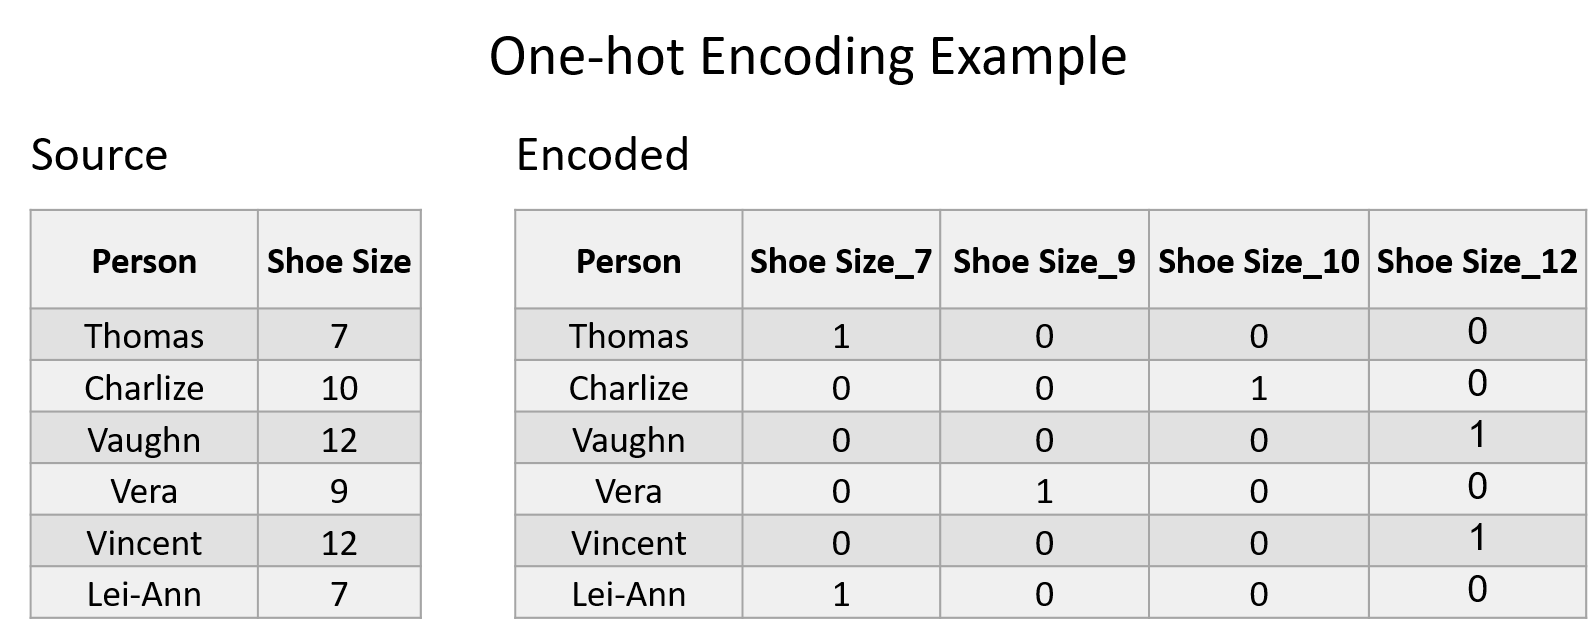

In [18]:
from IPython.display import Image
Image("../images/one_hot.png")

원핫 인코딩의 단점은 소스에서 가용하지 않은 새로운 상태룰 외삽하는 것이 불가능하다는 것이다. 위 예에서 소스 데이터에 사이즈 11이 없기 때문에 shoe size=11을 정의할 수 있는 방법이 없다. 이는 다운스트림 분석에서 shoe size=11 상태에 접근할 수 없게 되는 부작용을 낳는다.

In [19]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# fit and transform in one call and print categories
out_enc = enc.fit_transform(df[cats])
new_cols = enc.get_feature_names(cats).tolist()
print(new_cols)
# 실습자료랑은 같은 결과, 책이랑은 다른 결과. 뭔가 문법이 바뀐듯..? 책 102쪽.

['Jersey Size_0.0', 'Jersey Size_1.0', 'Jersey Size_2.0', 'Shoe Size_0.0', 'Shoe Size_1.0', 'Shoe Size_2.0', 'Shoe Size_3.0']


In [20]:
#원래 데이터와 연결된 df 생성
df_enc = pd.DataFrame(data=out_enc, columns=new_cols)
df_enc.index = df.index

# drop original columns and concat new encoded columns
df.drop(cats, axis=1, inplace=True)
df = pd.concat([df,df_enc], axis=1)
print(df.columns)

Index(['Age', 'Height', 'Weight', 'Training Hours/week', 'Jersey Color',
       'Long Jump', 'Jersey Size_0.0', 'Jersey Size_1.0', 'Jersey Size_2.0',
       'Shoe Size_0.0', 'Shoe Size_1.0', 'Shoe Size_2.0', 'Shoe Size_3.0'],
      dtype='object')


Label Encoding
-----
레이블 혹은 결과 열을 인코딩한다.

In [21]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()

out_enc = enc.fit_transform([1,2,5,2,4,2,5])
print(out_enc)

out_enc = enc.fit_transform(["blue","red","blue","green","red","red"])
print(out_enc)

[0 1 3 1 2 1 3]
[0 2 0 1 2 2]


## High-dimensional data

차원 수가 증가하면 사례(행)의 수는 기하급수적으로 증가한다(statistically significant representation of chunks of feature space require exponentially more and more examples (i.e., rows) as the number of dimensions (i.e., features) grows). 이를 '차원성의 저주'라고 한다. Failure to grow the number of examples with the number of dimensions causes the data set to become sparse and no longer be representative of ground truth. The common rule of thumb is you should have five examples for every one dimension. Based on my experience, I recommend pushing this ratio up to 10-to-1 if possible.

앞에서 나온 차원성의 저주 때문에, 작업을 하기 전에 특정 열의 개수를 줄여야 할 수도 있다 (Due to the curse of dimensionality, reduction of the number of feature columns is sometimes required before you can get any work done). However, there are also other reasons for reducing the dimensions. For example, plotting and visualizing scatter data on a 2D piece of paper or computer screen requires that you have only two dimensions to show.

There are two main strategies for reducing dimensions:
* Selection - Choose best features and eliminate others
* Transformation - Create new features that summarize combinations of the original ones

### Feature Selection

특징 선택은 두 가지의 큰 전략으로 이뤄진다. 첫 번째는 특징 필터링이며, 먼저 중요한 척도를 정의하고 가장 중요한 것만 필터링한다. 두번째는 래퍼(wrapper) 기법이며, 다운스트림 작업을 흉내내고 가장 좋은 결과를 선택하기 전에 다양한 조합을 샘플링한다. 즉, 특징의 부분 집합으로 여러 개의 미니 모델을 생성하고 가장 좋은 결과를 보여주는 것을 점수화한다.

#### 특징 필터링
특징 필터링 핵심은 간단하다. 목표가 중요성을 점수화하는 방법을 찾는 것이라면, 가장 중요한 것만 남기면 된다. 중요성을 점수화하는 방법은 여러 가지가 있으며, 가장 흔한 방법은 분산 한계점을 정의하고 상관계수에 대해 정렬하는 것이다.

#### 분산 한계점
이 기법은 한계점을 설정하고 그 값 아래에 있는 특징들을 제거하는 방법이다. 적합할 때 각 특징의 분산을 저장하는 사이킷런의 VarianceThreshold 객체를 사용해보기 위해, 우선 사전 적합을 하자. 사전 적합할 때는 모든 특징이 사전 적합 후에도 남아있게 하기 위해 한계점을 설정하지 않는다.

단계는 이와 같다- 
1. 한계점 없이 사전 적합
2. 분산의 분석
3. 한계점 선택
4. 선택된 한계점을 갖고 재적합

In [23]:
df = pd.read_csv("../data/iris.csv"); df.index.name = 'record'

# define columns to filter
cols = ['sepal length in cm',
        'sepal width in cm',
        'petal length in cm',
        'petal width in cm',]

# instantiate Scikit-learn object with no threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

# 이 부분은 정말 도저히 이해가 안된다 일단 패스

##### 상관계수(correlation coefficient)
상관성은 두 변수 간 일치성의 강도를 나타낸다. 피어슨의 r 상관계수는 가장 흔히 사용되는 상관성 지표다. -1~1 사이 값을 가지며, 0에 가까울수록 두 변수의 상관관계가 낮음을 의미하고, 양수는 양의 상관관계, 음수는 그 반대를 의미한다. 판다스의 .corr() 혹은 씨본의 heatmap을 사용해 시각적으로 복수의 r 상관계수를 한번에 분석할 수 있고, 결과에서 가장 높은 상관관계를 갖는 특징을 필터링할 수 있다.

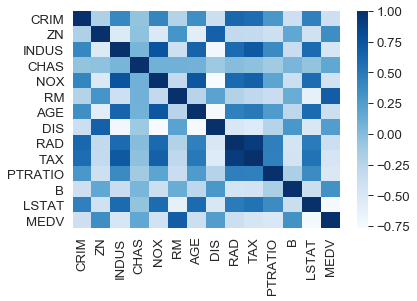

In [25]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

# Load and return the boston house-prices dataset (regression)
dataset = load_boston()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['MEDV'] = dataset.target; df.index.name = 'record'

cor = df.corr()
# heatmap 옵션들은 무슨 말인지 하나도 모르겠..
sns.heatmap(cor, annot=False, cmap=plt.cm.Blues)
plt.show()

위 다이어그램에서 우변의 스케일은 히트맵을 분석하는 데 도움을 준다. **진한 파란색은 더 강한 상관관계를 나타낸다.** 대각선은 자신과의 쌍이므로 모두 r=1이다. 이 데이터에서 단일 결과 변수('MEDV')만을 사용하므로, 그 결과 변수에 대해 각 입력과 결과의 쌍을 이루는 결과의 r 상관계수를 살펴보자.

In [26]:
# 타겟 변수에 대한 상관계수 값
cor_target = abs(cor['MEDV'])
cor_target

CRIM       0.388305
ZN         0.360445
INDUS      0.483725
CHAS       0.175260
NOX        0.427321
RM         0.695360
AGE        0.376955
DIS        0.249929
RAD        0.381626
TAX        0.468536
PTRATIO    0.507787
B          0.333461
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

편의상 0.6을 한계점으로 하고 필터링한다. 열 5, 12가 선택될 것이라고 예상할 수 있다.

In [32]:
selected_cols = cor_target[cor_target>0.6]
print("selected columns, correlation with target > 0.6", end='\n\n\n')
print(selected_cols, end='\n\n\n')

# filter in the selected features
df_sel = df[selected_cols.index]
print(df.head())

selected columns, correlation with target > 0.6


RM       0.695360
LSTAT    0.737663
MEDV     1.000000
Name: MEDV, dtype: float64


           CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
record                                                                       
0       0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1       0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2       0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3       0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4       0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

        PTRATIO       B  LSTAT  MEDV  
record                                
0          15.3  396.90   4.98  24.0  
1          17.8  396.90   9.14  21.6  
2          17.8  392.83   4.03  34.7  
3          18.7  394.63   2.94  33.4  
4          18.7  396.90   5.33  36.2  


래퍼 기법
-----
래퍼 기법은 보다 나은 예측을 위해 머신 러닝 알고리즘을 사용해 각 특징의 공헌도를 점수화한다. The sequential version then updates the feature list with each iteration of the algorithm fitting. You can do this in the forward or backward direction, meaning you can start with 0 features selected and add one of more in each iteration, or you can start with all available features and whittle away at them each time.

#### 순차적 특징 선택 (Sequential Feature Selection)
Sequential feature selection can work in the forward or backward direction, giving rise to the obviously named routines called forward sequential selection and backward sequential selection. Usually when practitioners use this terminology, they are referring to a routine where they decide the score function and update (feature add/remove) strategy themselves, writing custom code to accomplish. 예측 알고리즘의 자동 점수화를 사용할 의향이 있다면, 사이킷런은 내장된 반복적 특징 제거(recursive feature elimination)(RFE) 기법을 제공한다.

TIP: Scikit-learn's RFE method works with any prediction algorithm object that has a .coef_ or .featureimportances attribute in the fit object. There are quite a few candidate algorithms to choose from but I recommend LinearRegression() for continuous target variables and RandomForestClassifier() for categorical target variables.

In [33]:
df = pd.read_csv("../data/iris.csv"); df.index.name = 'record'

# define columns to select from
cols = ['sepal length in cm',
        'sepal width in cm',
        'petal length in cm',
        'petal width in cm',]

서포트 벡터 머신 분류기(SVC)를 예제 RFE에서 추정기로 사용한다. 이제 모듈을 불러오고 SVC 객체에 대해 독립변수 X와 종속변수 Y를 정의하자.

In [35]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

x = df[cols]
y = df['species']

svc = SVC(kernel="linear", C=1)
# 결과 특징 개수 = 2
rfe = RFE(estimator=svc, n_features_to_select=2, step=1)
# 적합
rfe.fit(x,y)

print(cols)
# 특징 랭킹 점검
print(rfe.ranking_)

['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm']
[3 2 1 1]


선택된 속성들은 1의 중요성을 가진다(이게 c값인가..?). 결과 특징 개수를 2개로 설정했으므로 이 객체는 2개의 특징을 선택하며, 이 경우 petal length, petal width가 선택됐다.


### 변환(transformation)
데이터 차원을 감소시키는 흔한 전략 중 하나다. 변환은 벡터 회전(데이터 회전)으로 생각할 수 있다. 여기서 중요한 것은 **어떻게 새로운 특징 벡터 방향을 선택하느냐**다. 여기에 두 가지 흔한 수학적 기법이 있고, 둘다 감독/비감독((un)supervised)인 경우에 완전히 확정적이고 타깃된 성질을 갖는다. 
데이터 차원을 감소시키는 흔한 전략 중 하나다. 변환은 벡터 회전(데이터 회전)으로 생각할 수 있다. 여기서 중요한 것은 **어떻게 새로운 특징 벡터 방향을 선택하느냐**다. There are two common mathematical methods, both of which are fully deterministic and targeted at either the supervised or unsupervised case.

여기서 이해를 돕기 위해 한 예가 나오는데, 책 112~3쪽에서 직접 보거나 실습자료에서 보자(길어서 다 옮겨올 수 없음). 감독 버전은 데이터에 레이블을 포함하고, 비감독 버전은 포함 ㄴㄴ. 레이블이 없는 비감독의 경우 가능한 한 많은 정보를 노출시키는 것이 목표다.

#### PCA
PCA는 비감독 방법으로 데이터의 차원을 감소시킬 때 사용된다. 이 기법의 목표는 새로운 특징 벡터를 파악하고, 데이터 분산을 최대화하고, 원래 데이터를 새로운 공간에 투사하는 것이다.
분산을 최대화하는 새로운 특징 벡터 = 고유벡터- 이것이 데이터의 주성분이 된다. 이 기법의 능력은 덜 중요한 성분을 버리고 가장 중요한 성분만 갖고 있음으로써 차원을 감소시킬 때 발휘된다. 사이킷런은 각 주요 성분의 중요성에 대해 순위를 매길 떄 사용될 수 있는 explained_variable_ 속성을 제공한다. n_components 옵션으로는 새롭게 정의된 낮은 차원을 표시하고 이 차원을 분산으로 정렬하고 특징들을 제거할 수 있다.

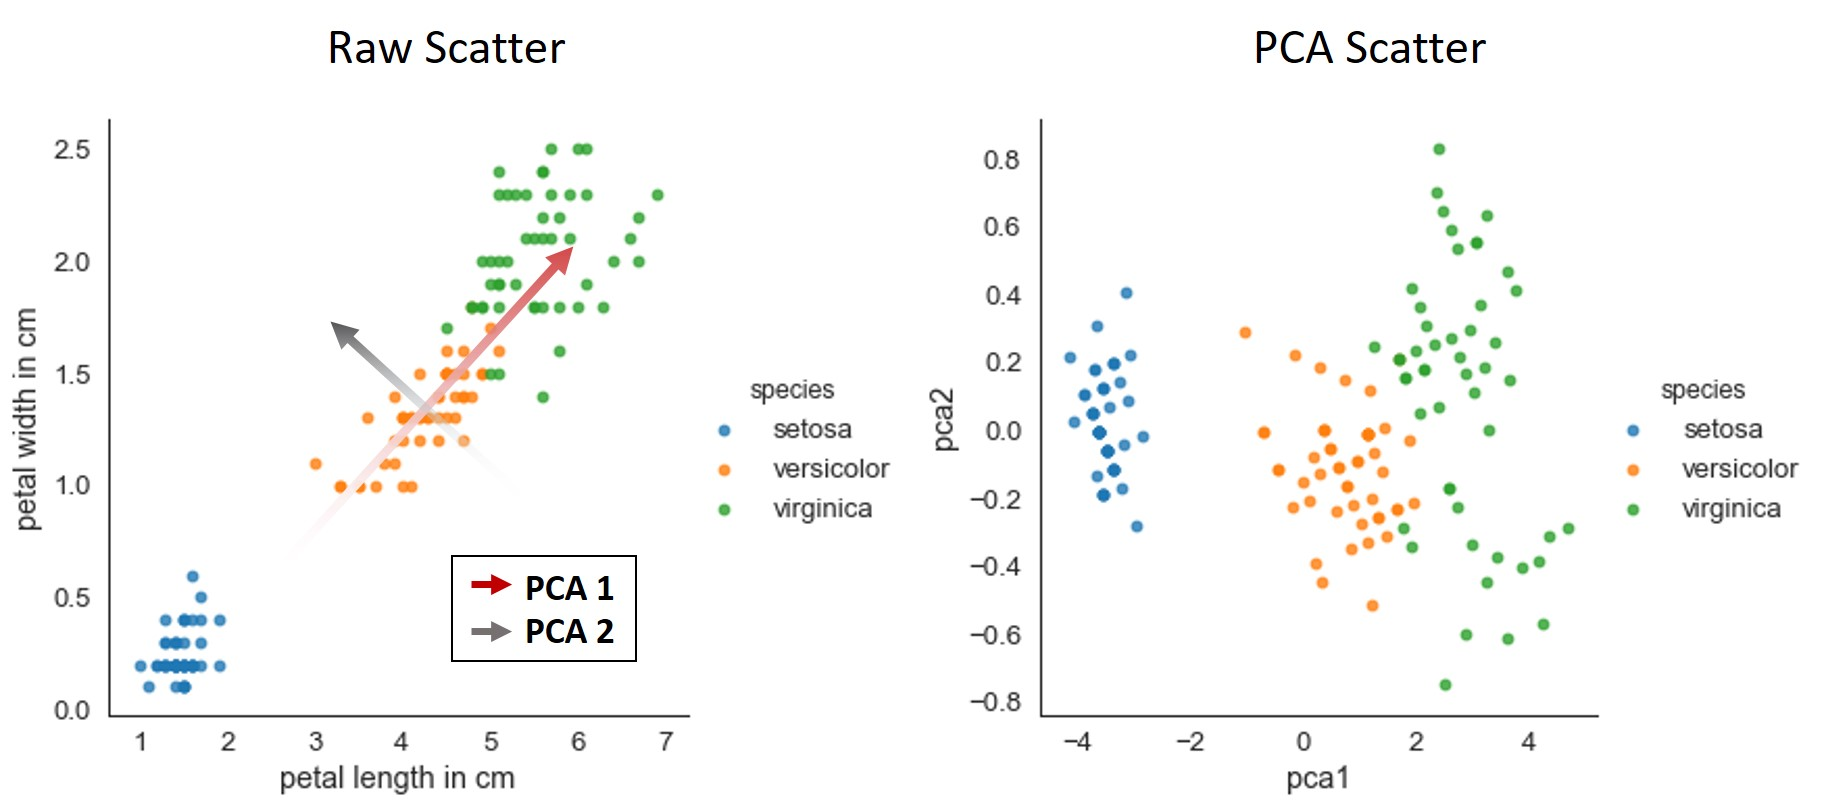

In [37]:
from IPython.display import Image
Image("../images/iris_scatter_raw_vs_pca.jpg")

위 사진에 대한 이해는 꼭 기억해야한다!!! 매우 중요하고 유용하다!!!! 위 사진은 PCA의 한 예다. iris 데이터의 원래 스캐터 플롯은 왼쪽에 표시됐다. 가장 큰 분산은 적색 화살표 방향에서 나타나고, 두번째로 큰 분산은 직각인 검정색. 이 둘을 축으로 데이터를 회전시켜 두 축이 두개의 주요성분이라고 상상해보자. Finally, study the PCA scatter plot on the right where the axes are the directions "PCA1" and "PCA2".

Now let's look at the Scikit-learn PCA object, syntax, and the code needed to create the scatter plot above :

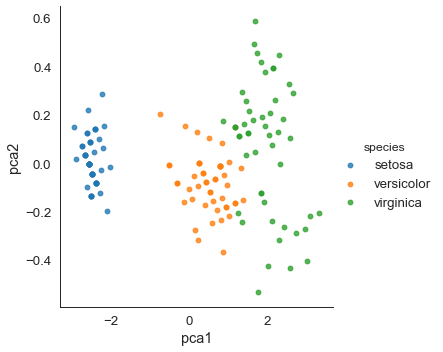

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# fit and transform using 2 input dimensions
out_pca = pca.fit_transform(df[['petal length in cm', 'petal width in cm',]])

# create pca output dataframe and add label column "species" 
df_pca = pd.DataFrame(data = out_pca, columns = ['pca1', 'pca2'])
df_pca = pd.concat([df_pca, df[['species']]], axis = 1)

# plot scatter of pca data
sns.lmplot(x='pca1', y='pca2', hue='species', data=df_pca, fit_reg=False)

...